In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # data visualization
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa import stattools
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import r2_score

### Source: https://github.com/jgehrcke/covid-19-germany-gae

In [14]:
cases=pd.read_csv('cases-rki-by-state.csv', index_col=0).reset_index()
cases=cases[['time_iso8601','sum_cases']]
tmp=pd.DataFrame(cases['sum_cases'])
tmp.index=pd.to_datetime(cases['time_iso8601'])
cases=tmp.copy()
cases=(cases-cases.shift(periods=1)).iloc[1:]
cases

,sum_cases
time_iso8601,
2020-03-03 17:00:00+00:00,85.0
2020-03-04 17:00:00+00:00,154.0
2020-03-05 17:00:00+00:00,184.0
2020-03-06 17:00:00+00:00,186.0
2020-03-07 17:00:00+00:00,141.0
...,...
2020-12-22 17:00:00+00:00,28406.0
2020-12-23 17:00:00+00:00,32556.0
2020-12-24 17:00:00+00:00,19878.0


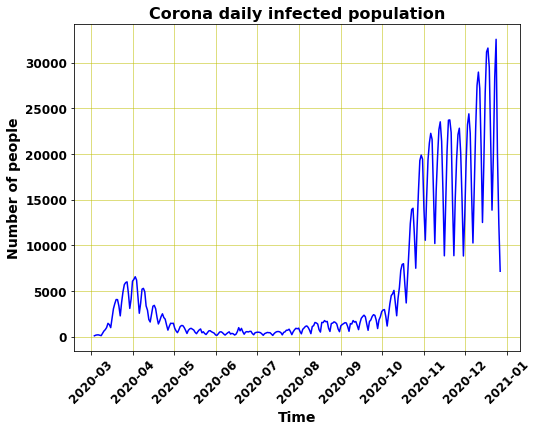

In [15]:
register_matplotlib_converters()

plt.figure(figsize=(8, 6))
plt.plot(cases, color='b')
plt.title('Corona daily infected population', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.ylabel('Number of people', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)

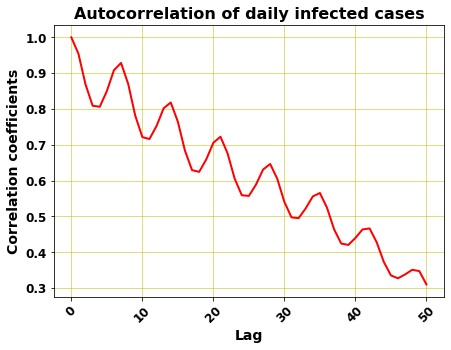

In [17]:
acf_djia, confint_djia, qstat_djia, pvalues_djia = stattools.acf(cases,
                                                             adjusted=True,
                                                             nlags=50,
                                                             qstat=True,
                                                             fft=True,
                                                             alpha = 0.05)

plt.figure(figsize=(7, 5))
plt.plot(pd.Series(acf_djia), color='r', linewidth=2)
plt.title('Autocorrelation of daily infected cases', weight='bold', fontsize=16)
plt.xlabel('Lag', weight='bold', fontsize=14)
plt.ylabel('Correlation coefficients', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)

In [19]:
def create_regressor_attributes(df, attribute, list_of_prev_t_instants) :
    
    """
    Ensure that the index is of datetime type
    Creates features with previous time instant values
    """
        
    list_of_prev_t_instants.sort()
    start = list_of_prev_t_instants[-1] 
    end = len(df)
    df['datetime'] = df.index
    df.reset_index(drop=True)

    df_copy = df[start:end]
    df_copy.reset_index(inplace=True, drop=True)

    for attribute in attribute :
            foobar = pd.DataFrame()

            for prev_t in list_of_prev_t_instants :
                new_col = pd.DataFrame(df[attribute].iloc[(start - prev_t) : (end - prev_t)])
                new_col.reset_index(drop=True, inplace=True)
                new_col.rename(columns={attribute : '{}_(t-{})'.format(attribute, prev_t)}, inplace=True)
                foobar = pd.concat([foobar, new_col], sort=False, axis=1)

            df_copy = pd.concat([df_copy, foobar], sort=False, axis=1)
            
    df_copy.set_index(['datetime'], drop=True, inplace=True)
    return df_copy

In [24]:
list_of_attributes = ['sum_cases']

list_of_prev_t_instants = np.arange(1,8).tolist()

df_new = create_regressor_attributes(cases, list_of_attributes, list_of_prev_t_instants)
df_new.head()

,sum_cases,sum_cases_(t-1),sum_cases_(t-2),sum_cases_(t-3),sum_cases_(t-4),sum_cases_(t-5),sum_cases_(t-6),sum_cases_(t-7)
datetime,,,,,,,,
2020-03-10 17:00:00+00:00,602.0,347.0,102.0,141.0,186.0,184.0,154.0,85.0
2020-03-11 17:00:00+00:00,757.0,602.0,347.0,102.0,141.0,186.0,184.0,154.0
2020-03-12 17:00:00+00:00,990.0,757.0,602.0,347.0,102.0,141.0,186.0,184.0
2020-03-13 17:00:00+00:00,1452.0,990.0,757.0,602.0,347.0,102.0,141.0,186.0
2020-03-14 17:00:00+00:00,1307.0,1452.0,990.0,757.0,602.0,347.0,102.0,141.0


In [30]:
input_layer = Input(shape=(7), dtype='float32')
dense1 = Dense(60, activation='linear')(input_layer)
dense2 = Dense(60, activation='linear')(dense1)
dropout_layer = Dropout(0.2)(dense2)
output_layer = Dense(1, activation='linear')(dropout_layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 60)                480       
_________________________________________________________________
dense_4 (Dense)              (None, 60)                3660      
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 61        
Total params: 4,201
Trainable params: 4,201
Non-trainable params: 0
_________________________________________________________________


In [27]:
test_set_size = 0.05
valid_set_size= 0.05

df_copy = df_new.reset_index(drop=True)

df_test = df_copy.iloc[ int(np.floor(len(df_copy)*(1-test_set_size))) : ]
df_train_plus_valid = df_copy.iloc[ : int(np.floor(len(df_copy)*(1-test_set_size))) ]

df_train = df_train_plus_valid.iloc[ : int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) ]
df_valid = df_train_plus_valid.iloc[ int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) : ]


X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_valid, y_valid = df_valid.iloc[:, 1:], df_valid.iloc[:, 0]
X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]

print('Shape of training inputs, training target:', X_train.shape, y_train.shape)
print('Shape of validation inputs, validation target:', X_valid.shape, y_valid.shape)
print('Shape of test inputs, test target:', X_test.shape, y_test.shape)

Shape of training inputs, training target: (263, 7) (263,)
Shape of validation inputs, validation target: (14, 7) (14,)
Shape of test inputs, test target: (15, 7) (15,)


In [28]:
from sklearn.preprocessing import MinMaxScaler

Target_scaler = MinMaxScaler(feature_range=(0.01, 0.99))
Feature_scaler = MinMaxScaler(feature_range=(0.01, 0.99))

X_train_scaled = Feature_scaler.fit_transform(np.array(X_train))
X_valid_scaled = Feature_scaler.fit_transform(np.array(X_valid))
X_test_scaled = Feature_scaler.fit_transform(np.array(X_test))

y_train_scaled = Target_scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_valid_scaled = Target_scaler.fit_transform(np.array(y_valid).reshape(-1,1))
y_test_scaled = Target_scaler.fit_transform(np.array(y_test).reshape(-1,1))

In [31]:
model.fit(x=X_train_scaled, y=y_train_scaled, batch_size=5, epochs=30, verbose=1, validation_data=(X_valid_scaled, y_valid_scaled), shuffle=True)

Train on 263 samples, validate on 14 samples
Epoch 1/30
263/263 [==============================] - 1s 5ms/sample - loss: 0.0163 - val_loss: 0.0182
Epoch 2/30
263/263 [==============================] - 0s 630us/sample - loss: 0.0109 - val_loss: 0.0100
Epoch 3/30
263/263 [==============================] - 0s 583us/sample - loss: 0.0071 - val_loss: 0.0164
Epoch 4/30
263/263 [==============================] - 0s 549us/sample - loss: 0.0074 - val_loss: 0.0317
Epoch 5/30
263/263 [==============================] - 0s 562us/sample - loss: 0.0068 - val_loss: 0.0106
Epoch 6/30
263/263 [==============================] - 0s 574us/sample - loss: 0.0039 - val_loss: 0.0134
Epoch 7/30
263/263 [==============================] - 0s 634us/sample - loss: 0.0073 - val_loss: 0.0245
Epoch 8/30
263/263 [==============================] - 0s 640us/sample - loss: 0.0052 - val_loss: 0.0180
Epoch 9/30
263/263 [==============================] - 0s 590us/sample - loss: 0.0044 - val_loss: 0.0095
Epoch 10/30
263/263 [

In [32]:
y_pred = model.predict(X_test_scaled)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)

In [33]:
from sklearn.metrics import r2_score
y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set:', round(score,4))

R-squared score for the test set: 0.5867


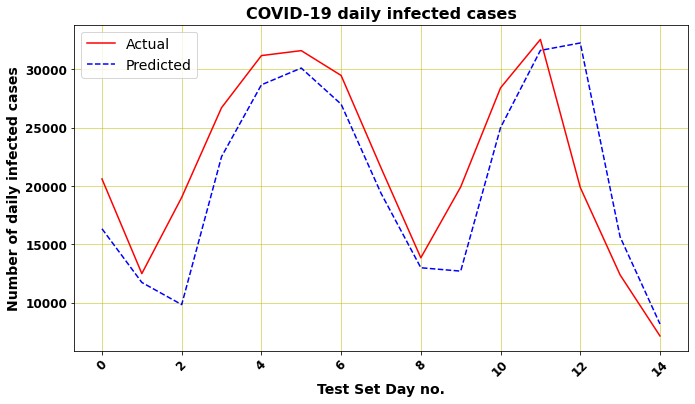

In [34]:
y_actual = pd.DataFrame(y_test_rescaled, columns=['Actual daily infected cases'])

y_hat = pd.DataFrame(y_pred_rescaled, columns=['Predicted daily infected cases'])
plt.figure(figsize=(11, 6))
plt.plot(y_actual, linestyle='solid', color='r')
plt.plot(y_hat, linestyle='dashed', color='b')

plt.legend(['Actual','Predicted'], loc='best', prop={'size': 14})
plt.title('COVID-19 daily infected cases', weight='bold', fontsize=16)
plt.ylabel('Number of daily infected cases', weight='bold', fontsize=14)
plt.xlabel('Test Set Day no.', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth='0.5')
plt.show()